In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import sys
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'
import itertools
import matplotlib as mpl

/tmp/ipykernel_2336/4094593379.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load output:

In [2]:
in_dir = '/home/jovyan/CMIP6cex/output/num_extremes/sfcWind_pr_europe/40yr_p98_lag0d_declus1d_ref2000/'
output_files = []
ssps = ['ssp245','ssp585']

source_ids = [k for k in os.listdir(in_dir) if ~k.startswith('.')]

for s,ssp in enumerate(ssps):
    models = []
    for so,source_id in enumerate(source_ids): #loop over models
        model_path = os.path.join(in_dir,source_id)
        model_ssp_ds = {}

        files = [os.path.join(model_path,f) for f in os.listdir(model_path) if ssp in f]
        if len(files)>0:
            model_ds = xr.open_mfdataset(files,concat_dim='member_id',combine='nested',coords='minimal',compat='override',join='outer').chunk(member_id=100)
            models.append(source_id)
        else:
            continue

        if so==0:
            ssp_ds = model_ds
        else:
            ssp_ds = xr.concat((ssp_ds,model_ds),dim='source_id',coords='minimal',join='outer')
            
    ssp_ds = ssp_ds.assign_coords({'source_id':models})   
    
    
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp')
ds = ds.assign_coords({'ssp':ssps})

ds = ds.sel(window=slice(1980,2100))

complete = ds.complete_window.sel(window=slice(1980,2100)).sum(dim='window')==len(ds.complete_window.sel(window=slice(1980,2100)).window)
ds = ds.where(complete) #require runs to be complete from 1970 to 2100

ds_intersect = ds.where(np.isfinite(ds.complete_window.isel(window=-1)).all(dim=['ssp','longitude','latitude'])) #only consider where we have both SSPs

n_wp = ds_intersect[['num_joint_extremes']]
n_wp = n_wp.num_joint_extremes.load()
n_wp = n_wp.sum(dim='month',skipna=False)

In [3]:
in_dir = '/home/jovyan/CMIP6cex/output/num_extremes/surge_g2_pr_tgs/40yr_p98_lag0d_declus1d_ref2000/'
output_files = []
ssps = ['ssp245','ssp585']

source_ids = [k for k in os.listdir(in_dir) if ~k.startswith('.')]

for s,ssp in enumerate(ssps):
    models = []
    for so,source_id in enumerate(source_ids): #loop over models
        model_path = os.path.join(in_dir,source_id)
        model_ssp_ds = {}

        files = [os.path.join(model_path,f) for f in os.listdir(model_path) if ssp in f]
        if len(files)>0:
            model_ds = xr.open_mfdataset(files,concat_dim='member_id',combine='nested',coords='minimal',compat='override',join='outer').chunk(member_id=100)
            models.append(source_id)
        else:
            continue

        if so==0:
            ssp_ds = model_ds
        else:
            ssp_ds = xr.concat((ssp_ds,model_ds),dim='source_id',coords='minimal',join='outer',compat='override')
            
    ssp_ds = ssp_ds.assign_coords({'source_id':models})   
    
    
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp')
ds = ds.assign_coords({'ssp':ssps})

ds = ds.sel(window=slice(1980,2100))

complete = ds.complete_window.sel(window=slice(1980,2100)).sum(dim='window')==len(ds.complete_window.sel(window=slice(1980,2100)).window)
ds = ds.where(complete) #require runs to be complete from 1970 to 2100

ds_intersect = ds.where(np.isfinite(ds.complete_window.isel(window=-1)).all(dim=['ssp','tg'])) #only consider where we have both SSPs

#plot changes in number of joint extremes
n_sp = ds_intersect[['num_joint_extremes']]
n_sp = n_sp.load()
n_sp=n_sp.where(n_sp.tg!='le_pellerin_.csv',drop=True)
n_sp = n_sp.where(n_sp.tg!='nantes_usine_brulee_.csv',drop=True)
n_sp = n_sp.num_joint_extremes.load()
n_sp = n_sp.sum(dim='month',skipna=False)

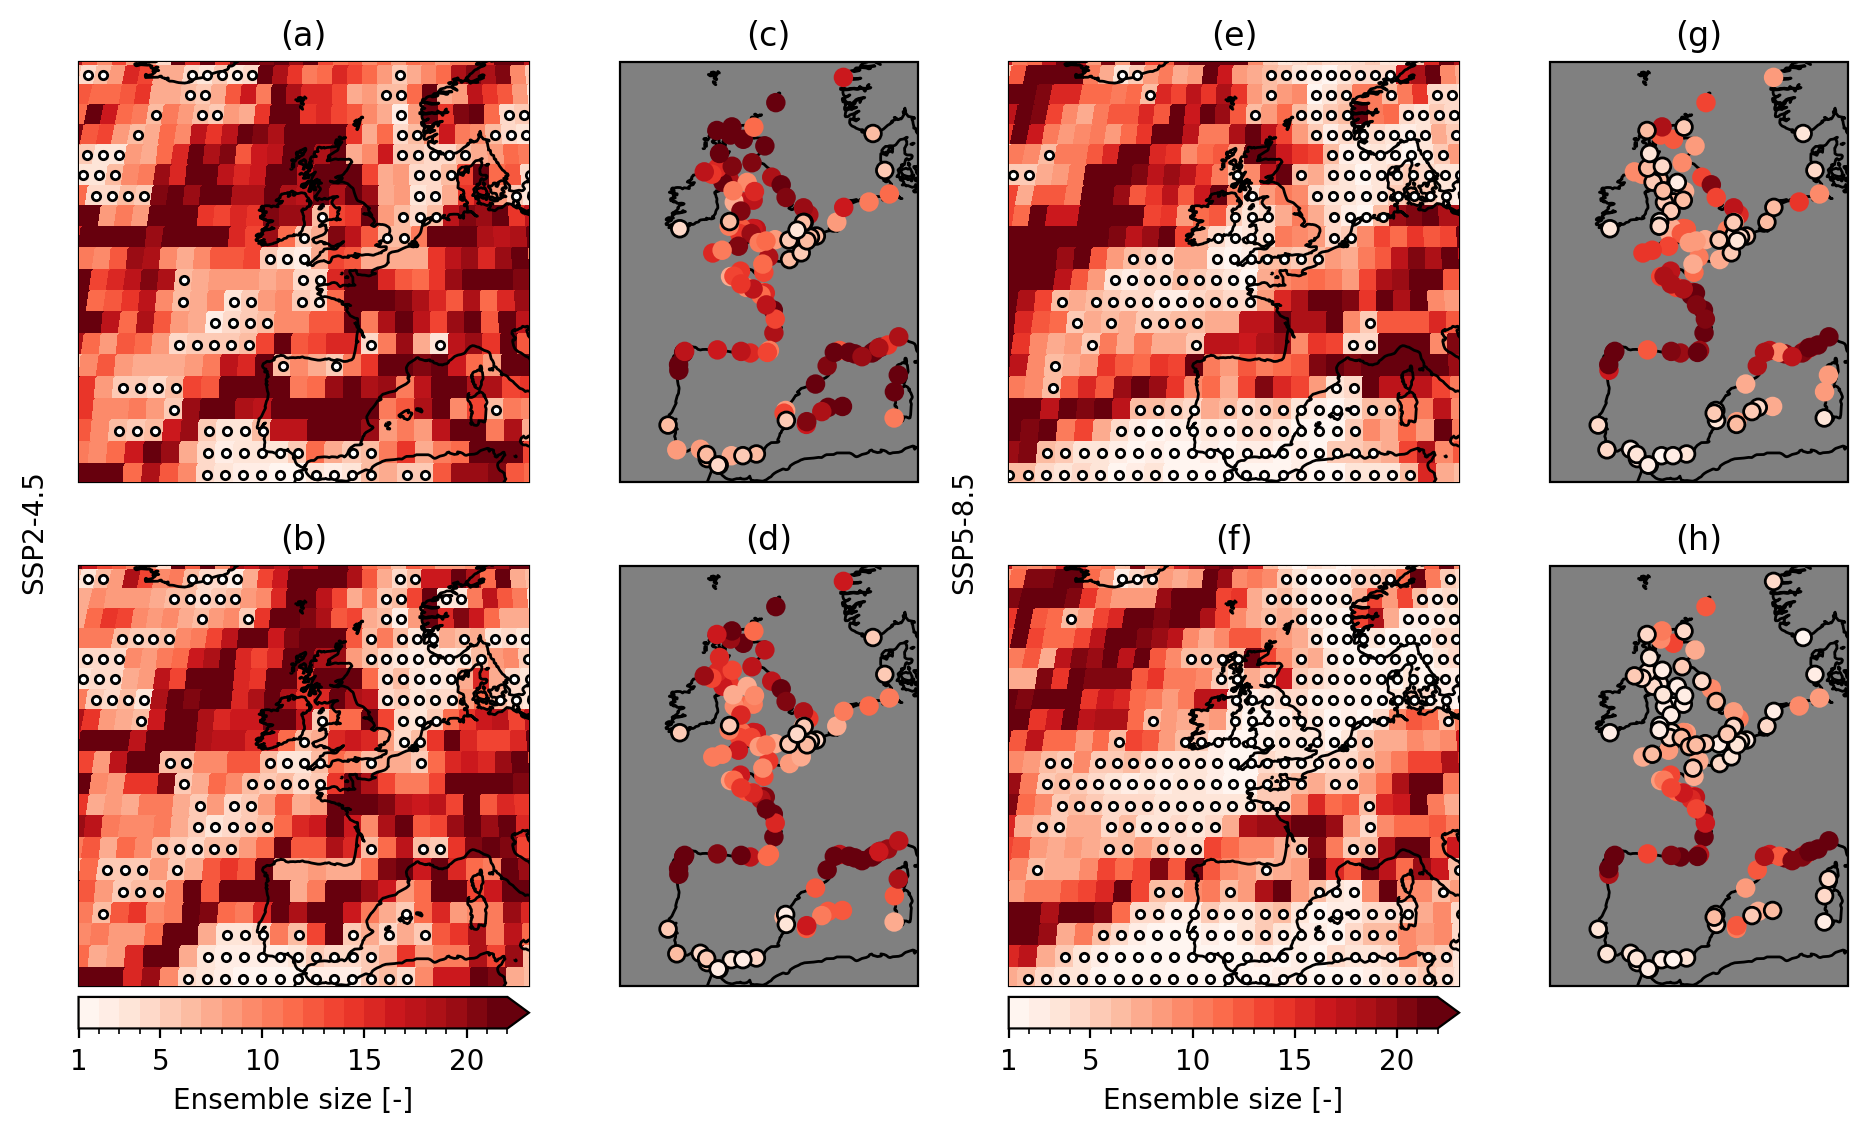

In [8]:
cmap = plt.cm.Reds # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(1, 22, 22)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        
np.random.seed(seed=0)

fig=plt.figure(figsize=(12,6)) #generate figure  
gs = fig.add_gridspec(2,6)
gs.update(wspace=.001)

for s,ssp in enumerate(['ssp245','ssp585']):
    for w,window in enumerate(np.array([2060,2080])):
        ssp_ds_diff = (n_wp.sel(window=window)-n_wp.sel(window=2000)).sel(ssp=ssp)#n_wp_diff.sel(ssp=ssp)

        
        finite_mems = np.isfinite(ssp_ds_diff.isel(latitude=0,longitude=0))

        members= np.zeros((len(ssp_ds_diff.source_id)))
        for i in np.arange(len(ssp_ds_diff.source_id)):
            try:
                members[i] = np.where(finite_mems[i,:])[0][0]
            except:
                members[i] = 0
        ix = xr.DataArray(members,dims=['source_id'],coords={'source_id':ssp_ds_diff.source_id})

        onemem_ens = ssp_ds_diff.isel(member_id=ix.astype('int')).dropna(dim='source_id')
        n_samps = 2000
        for i in np.arange(len(onemem_ens.source_id)-1):
            n_models = i+1
            combs = list(itertools.combinations(np.arange(len(onemem_ens.source_id)), n_models))
            if len(combs)>n_samps:
                idx=np.random.randint(0,len(combs),size=n_samps)
                idx_ds = xr.DataArray(np.array([combs[k] for k in idx]),dims=['n','model'])
            else:
                idx_ds = xr.DataArray(np.array([combs[k] for k in np.arange(len(combs))]),dims=['n','model'])
        
            signs = np.sign(onemem_ens.isel(source_id=idx_ds).mean(dim='model'))
            frac_positive = (signs==np.sign(ssp_ds_diff.mean(dim='member_id').mean(dim='source_id'))).sum(dim='n')/len(signs.n)
            if i==0:
                frac_positive_ds = frac_positive
            else:
                frac_positive_ds = xr.concat((frac_positive_ds,frac_positive),dim='n_models')
        frac_positive_ds = frac_positive_ds.assign_coords({'n_models':np.arange(len(onemem_ens.source_id)-1)+1})
        
        
        agrees = frac_positive_ds>=.95
        
        subsequent_sum = frac_positive_ds.copy(deep=True)
        for k in np.arange(len(agrees.n_models)):
            subsequent_sum[k,:,:] = agrees.where(agrees==1).isel(n_models=np.arange(k,len(agrees.n_models))).sum(dim='n_models',skipna=False).values
        
        
        #test = frac_positive_ds.where(frac_positive_ds>=.9,-999)
        
        agrees = agrees.where(np.isfinite(subsequent_sum),-999)
        #test = test.where(test!=0)
        first_n = agrees.argmax(dim='n_models')#.where(~np.isfinite(frac_positive_ds.where((frac_positive_ds>.1) & (frac_positive_ds<.9))))
        #first_n = first_n.where(frac_positive_ds.where(frac_positive_ds>=.9).all(dim='n_models'))
        first_n = first_n.where(agrees.any(dim='n_models'),100)
        first_n = first_n.where(np.isfinite(subsequent_sum.isel(n_models=first_n.astype('int'))),100)
        first_n = first_n+1
        #first n and all subsequent n also?
        
        
        
        if ssp=='ssp245':                                                                             
            ax = plt.subplot(gs[w,0:2],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

            sc = (first_n).plot(cmap=cmap,norm=norm,vmin=1,vmax=22,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            [LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=5)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
            if w==1:
                cax=ax.inset_axes(bounds=(0, -.1,1,.075))
                cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Ensemble size [-]',extend='max')
                cb.set_ticks(np.array([1,5,10,15,20]))
                cb.set_ticklabels(['1','5','10','15','20'])
            ax.set_title(['(a)','(b)'][w])

            sc.set_edgecolor('face')
         
        
        if ssp=='ssp585':                                                                             
            ax = plt.subplot(gs[w,3:5],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            
            cmap = plt.cm.Reds # define the colormap
            # extract all colors from the .jet map
            cmaplist = [cmap(i) for i in range(cmap.N)]

            cmap = mpl.colors.LinearSegmentedColormap.from_list(
                'Custom cmap', cmaplist, cmap.N)
            bounds = np.linspace(1, 22, 22)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
            sc = (first_n).plot(cmap=cmap,vmin=1,vmax=22,transform=ccrs.PlateCarree(),zorder=3,ax=ax,norm=norm,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            [LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=5)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
            if w==1:
                cax=ax.inset_axes(bounds=(0, -.1,1,.075))
                cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Ensemble size [-]',extend='max')
                cb.set_ticks(np.array([1,5,10,15,20]))
                cb.set_ticklabels(['1','5','10','15','20'])
            ax.set_title(['(e)','(f)'][w])

            sc.set_edgecolor('face')
        if (w==0):
            ax.annotate(['SSP2-4.5','SSP5-8.5'][s],xy=(-.13,-.25),xycoords='axes fraction',rotation=90)  
                
           
        #surges
        ssp_ds_diff = (n_sp.sel(window=window)-n_sp.sel(window=2000)).sel(ssp=ssp)#n_wp_diff.sel(ssp=ssp)


        finite_mems = np.isfinite(ssp_ds_diff.isel(tg=0))

        members= np.zeros((len(ssp_ds_diff.source_id)))
        for i in np.arange(len(ssp_ds_diff.source_id)):
            try:
                members[i] = np.where(finite_mems[i,:])[0][0]
            except:
                members[i] = 0
        ix = xr.DataArray(members,dims=['source_id'],coords={'source_id':ssp_ds_diff.source_id})

        onemem_ens = ssp_ds_diff.isel(member_id=ix.astype('int')).dropna(dim='source_id')
        n_samps = 2000
        for i in np.arange(len(onemem_ens.source_id)-1):
            n_models = i+1
            combs = list(itertools.combinations(np.arange(len(onemem_ens.source_id)), n_models))
            if len(combs)>n_samps:
                idx=np.random.randint(0,len(combs),size=n_samps)
                idx_ds = xr.DataArray(np.array([combs[k] for k in idx]),dims=['n','model'])
            else:
                idx_ds = xr.DataArray(np.array([combs[k] for k in np.arange(len(combs))]),dims=['n','model'])

            signs = np.sign(onemem_ens.isel(source_id=idx_ds).mean(dim='model'))
            frac_positive = (signs==np.sign(ssp_ds_diff.mean(dim='member_id').mean(dim='source_id'))).sum(dim='n')/len(signs.n)
            if i==0:
                frac_positive_ds = frac_positive
            else:
                frac_positive_ds = xr.concat((frac_positive_ds,frac_positive),dim='n_models')
        frac_positive_ds = frac_positive_ds.assign_coords({'n_models':np.arange(len(onemem_ens.source_id)-1)+1})


        agrees = frac_positive_ds>=.99

        subsequent_sum = frac_positive_ds.copy(deep=True)
        for k in np.arange(len(agrees.n_models)):
            subsequent_sum[k,:] = agrees.where(agrees==1).isel(n_models=np.arange(k,len(agrees.n_models))).sum(dim='n_models',skipna=False).values


        #test = frac_positive_ds.where(frac_positive_ds>=.9,-999)

        agrees = agrees.where(np.isfinite(subsequent_sum),-999)
        #test = test.where(test!=0)
        first_n = agrees.argmax(dim='n_models')#.where(~np.isfinite(frac_positive_ds.where((frac_positive_ds>.1) & (frac_positive_ds<.9))))
        #first_n = first_n.where(frac_positive_ds.where(frac_positive_ds>=.9).all(dim='n_models'))
        first_n = first_n.where(agrees.any(dim='n_models'),100)
        first_n = first_n.where(np.isfinite(subsequent_sum.isel(n_models=first_n.astype('int'))),100)
        first_n = first_n+1
        #first n and all subsequent n also?


        if ssp=='ssp245':                                                                             
            ax = plt.subplot(gs[w,2],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            sc=ax.scatter(n_sp.lon[first_n<7],n_sp.lat[first_n<7],c=first_n[first_n<7],cmap=cmap,norm=norm,edgecolor='black',transform=ccrs.PlateCarree(),zorder=4)
            sc=ax.scatter(n_sp.lon[first_n>6],n_sp.lat[first_n>6],c=first_n[first_n>6],cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=3)

            #sc = (first_n).plot(cmap='Reds',vmin=1,vmax=22,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            #[LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            #ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=1)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
            
            ax.set_title(['(c)','(d)'][w])
            
            sc.set_edgecolor('face')
            
        if ssp=='ssp585':                                                                       
            ax = plt.subplot(gs[w,5],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            sc=ax.scatter(n_sp.lon[first_n<7],n_sp.lat[first_n<7],c=first_n[first_n<7],cmap=cmap,norm=norm,edgecolor='black',transform=ccrs.PlateCarree(),zorder=4)
            sc=ax.scatter(n_sp.lon[first_n>6],n_sp.lat[first_n>6],c=first_n[first_n>6],cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=3)

            #sc = (first_n).plot(cmap='Reds',vmin=1,vmax=22,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            #[LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            #ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=1)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
           
            ax.set_title(['(g)','(h)'][w])

            sc.set_edgecolor('face')
      
#fig.savefig('Figures/req_enssize_cmip6.pdf',format='pdf',dpi=300,bbox_inches='tight')


In [6]:
frac_positive_ds.sel(n_models=5)

<xarray.DataArray 'num_joint_extremes' (tg: 122)>
array([0.6425, 0.9395, 0.9395, 0.946 , 0.9585, 0.962 , 0.958 , 1.    ,
       1.    , 1.    , 0.97  , 0.9195, 0.845 , 0.974 , 0.923 , 1.    ,
       0.6465, 0.5405, 1.    , 0.998 , 1.    , 0.9995, 0.8615, 0.874 ,
       1.    , 1.    , 1.    , 1.    , 0.9635, 0.8715, 0.7415, 0.8525,
       0.5775, 0.9285, 0.7855, 0.8725, 1.    , 0.6215, 0.999 , 0.924 ,
       0.921 , 0.915 , 1.    , 0.938 , 0.515 , 0.9995, 1.    , 0.7395,
       0.907 , 1.    , 1.    , 0.9585, 0.8125, 1.    , 0.538 , 0.999 ,
       1.    , 1.    , 1.    , 0.64  , 0.9995, 0.9935, 1.    , 1.    ,
       0.992 , 0.466 , 0.928 , 0.9995, 0.996 , 0.5905, 0.9995, 0.7845,
       0.91  , 0.9805, 1.    , 0.795 , 0.9975, 0.661 , 0.5005, 1.    ,
       1.    , 1.    , 0.861 , 0.6595, 0.999 , 0.8425, 0.9665, 1.    ,
       1.    , 1.    , 0.5045, 0.9815, 0.7345, 0.9785, 0.4415, 0.7835,
       1.    , 1.    , 0.5345, 1.    , 0.71  , 1.    , 1.    , 0.892 ,
       0.9585, 1.    , 0.9765, 0.861 , 0.9895, 1.    , 0.991 , 0.981 ,
       1.    , 0.845 , 1.    , 0.99  , 1.    , 0.997 , 0.9795, 1.    ,
       0.8615, 0.999 ])
Coordinates:
  * tg            (tg) object 'arcachon_eyrac_.csv' ... 'maaloey_003_norway.csv'
    gridcell_lat  (tg) float32 44.37 46.9 41.83 46.9 ... 50.7 51.97 43.1 62.11
    gridcell_lon  (tg) float32 0.0 357.5 2.5 357.5 ... 355.0 355.0 355.0 5.0
    lat           (tg) float64 44.66 47.31 41.34 47.29 ... 50.1 51.7 43.56 61.93
    lon           (tg) float64 -1.164 -2.108 2.163 -2.0 ... -5.014 -5.698 5.113
    quantile      float64 0.98
    ssp           <U6 'ssp585'
    n_models      int64 5

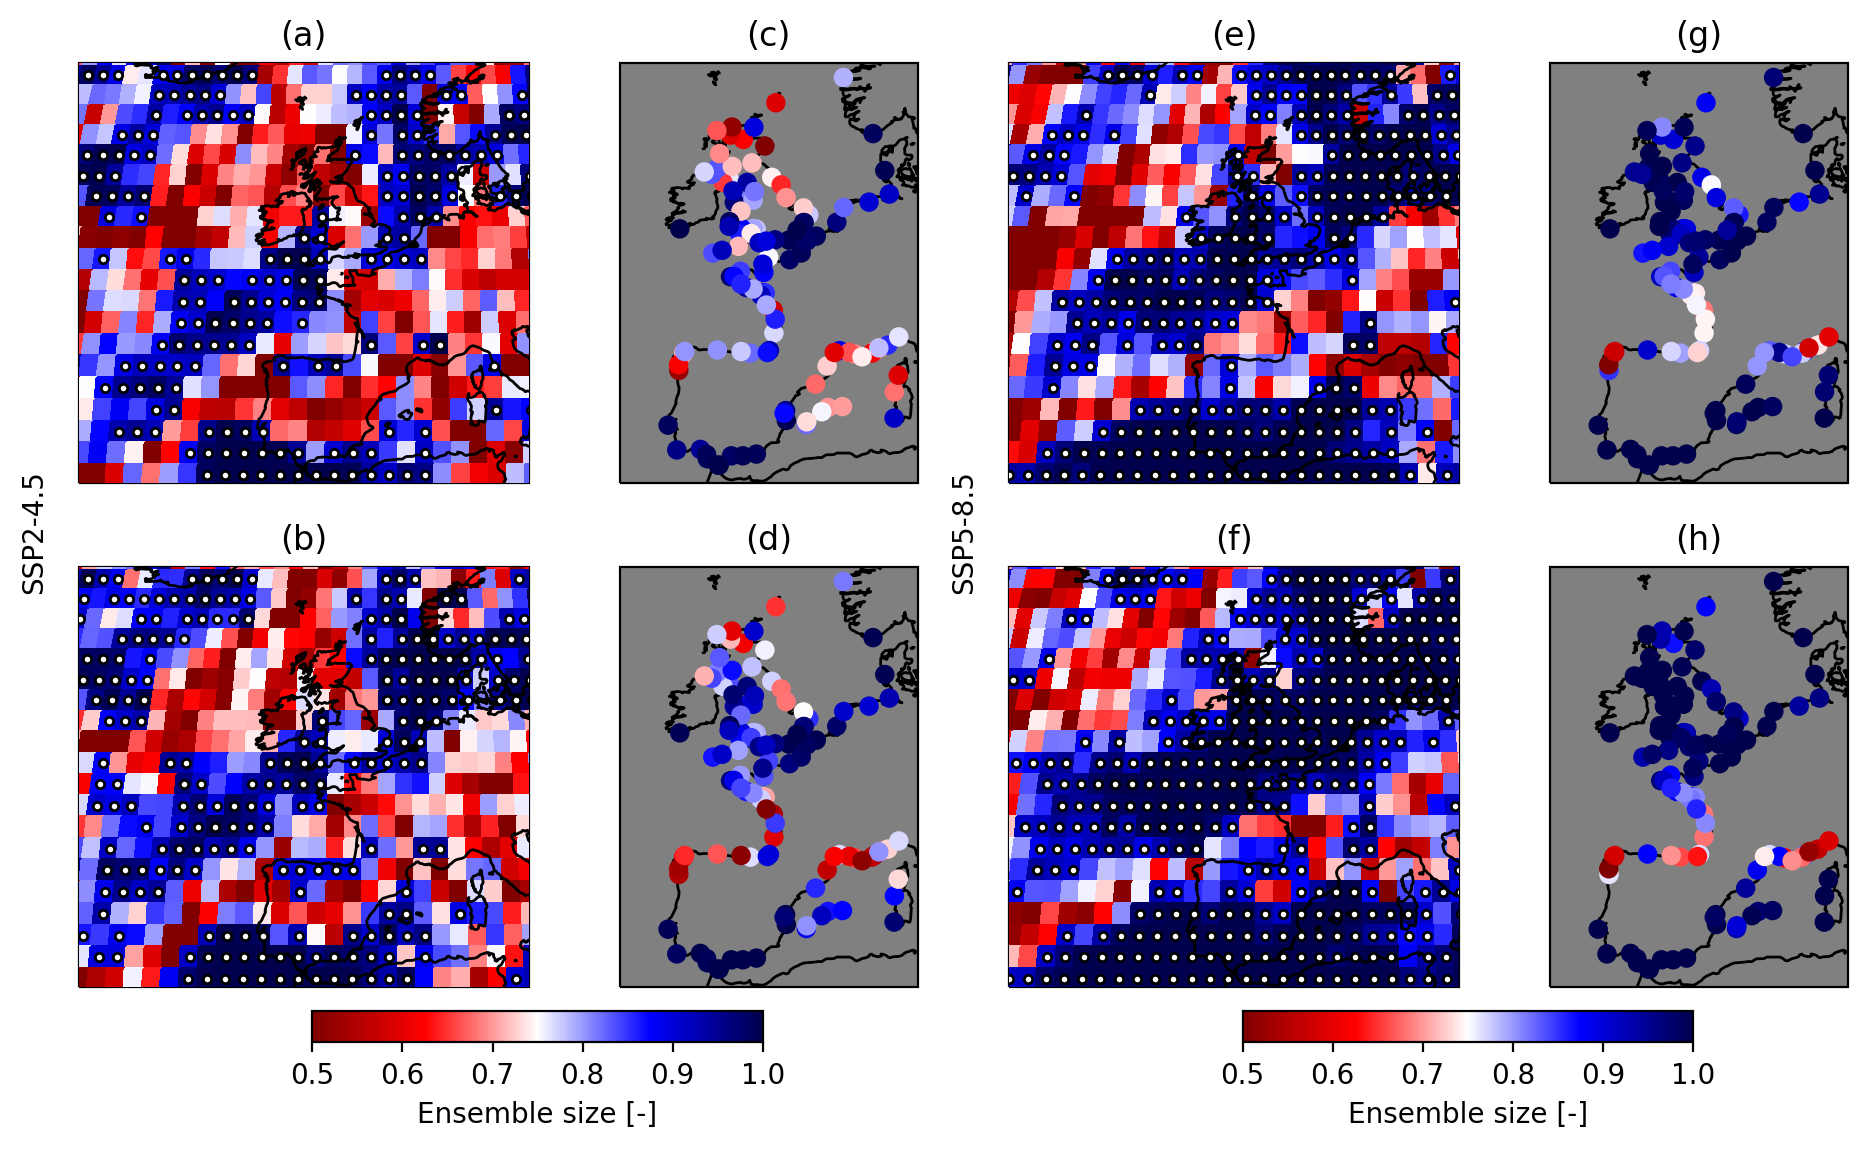

In [17]:
cmap = plt.cm.Reds # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(1, 22, 22)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        
np.random.seed(seed=0)

fig=plt.figure(figsize=(12,6)) #generate figure  
gs = fig.add_gridspec(2,6)
gs.update(wspace=.001)

for s,ssp in enumerate(['ssp245','ssp585']):
    for w,window in enumerate(np.array([2060,2080])):
        ssp_ds_diff = (n_wp.sel(window=window)-n_wp.sel(window=2000)).sel(ssp=ssp)#n_wp_diff.sel(ssp=ssp)

        
        finite_mems = np.isfinite(ssp_ds_diff.isel(latitude=0,longitude=0))

        members= np.zeros((len(ssp_ds_diff.source_id)))
        for i in np.arange(len(ssp_ds_diff.source_id)):
            try:
                members[i] = np.where(finite_mems[i,:])[0][0]
            except:
                members[i] = 0
        ix = xr.DataArray(members,dims=['source_id'],coords={'source_id':ssp_ds_diff.source_id})

        onemem_ens = ssp_ds_diff.isel(member_id=ix.astype('int')).dropna(dim='source_id')
        n_samps = 2000
        for i in np.arange(len(onemem_ens.source_id)-1):
            n_models = i+1
            combs = list(itertools.combinations(np.arange(len(onemem_ens.source_id)), n_models))
            if len(combs)>n_samps:
                idx=np.random.randint(0,len(combs),size=n_samps)
                idx_ds = xr.DataArray(np.array([combs[k] for k in idx]),dims=['n','model'])
            else:
                idx_ds = xr.DataArray(np.array([combs[k] for k in np.arange(len(combs))]),dims=['n','model'])
        
            signs = np.sign(onemem_ens.isel(source_id=idx_ds).mean(dim='model'))
            frac_positive = (signs==np.sign(ssp_ds_diff.mean(dim='member_id').mean(dim='source_id'))).sum(dim='n')/len(signs.n)
            if i==0:
                frac_positive_ds = frac_positive
            else:
                frac_positive_ds = xr.concat((frac_positive_ds,frac_positive),dim='n_models')
        frac_positive_ds = frac_positive_ds.assign_coords({'n_models':np.arange(len(onemem_ens.source_id)-1)+1})
        
        
        agrees = frac_positive_ds>=.9
        
        subsequent_sum = frac_positive_ds.copy(deep=True)
        for k in np.arange(len(agrees.n_models)):
            subsequent_sum[k,:,:] = agrees.where(agrees==1).isel(n_models=np.arange(k,len(agrees.n_models))).sum(dim='n_models',skipna=False).values
        
        
        #test = frac_positive_ds.where(frac_positive_ds>=.9,-999)
        
        agrees = agrees.where(np.isfinite(subsequent_sum),-999)
        #test = test.where(test!=0)
        first_n = agrees.argmax(dim='n_models')#.where(~np.isfinite(frac_positive_ds.where((frac_positive_ds>.1) & (frac_positive_ds<.9))))
        #first_n = first_n.where(frac_positive_ds.where(frac_positive_ds>=.9).all(dim='n_models'))
        first_n = first_n.where(agrees.any(dim='n_models'),100)
        first_n = first_n.where(np.isfinite(subsequent_sum.isel(n_models=first_n.astype('int'))),100)
        first_n = first_n+1
        #first n and all subsequent n also?
        
        
        
        if ssp=='ssp245':                                                                             
            ax = plt.subplot(gs[w,0:2],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

            sc = (frac_positive_ds.sel(n_models=5)).plot(cmap='seismic_r',vmin=.5,vmax=1,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            [LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=5)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
            if w==1:
                cax=ax.inset_axes(bounds=(0, -.1,1,.075))
                cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Ensemble size [-]')

            ax.set_title(['(a)','(b)'][w])

            sc.set_edgecolor('face')
         
        
        if ssp=='ssp585':                                                                             
            ax = plt.subplot(gs[w,3:5],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            
            cmap = plt.cm.Reds # define the colormap
            # extract all colors from the .jet map
            cmaplist = [cmap(i) for i in range(cmap.N)]

            cmap = mpl.colors.LinearSegmentedColormap.from_list(
                'Custom cmap', cmaplist, cmap.N)
            bounds = np.linspace(1, 22, 22)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
            sc = (frac_positive_ds.sel(n_models=5)).plot(cmap='seismic_r',vmin=.5,vmax=1,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            [LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=5)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
            if w==1:
                cax=ax.inset_axes(bounds=(0, -.1,1,.075))
                cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Ensemble size [-]')

            ax.set_title(['(e)','(f)'][w])

            sc.set_edgecolor('face')
        if (w==0):
            ax.annotate(['SSP2-4.5','SSP5-8.5'][s],xy=(-.13,-.25),xycoords='axes fraction',rotation=90)  
                
           
        #surges
      
        ssp_ds_diff = (n_sp.sel(window=window)-n_sp.sel(window=2000)).sel(ssp=ssp)#n_wp_diff.sel(ssp=ssp)


        finite_mems = np.isfinite(ssp_ds_diff.isel(tg=0))

        members= np.zeros((len(ssp_ds_diff.source_id)))
        for i in np.arange(len(ssp_ds_diff.source_id)):
            try:
                members[i] = np.where(finite_mems[i,:])[0][0]
            except:
                members[i] = 0
        ix = xr.DataArray(members,dims=['source_id'],coords={'source_id':ssp_ds_diff.source_id})

        onemem_ens = ssp_ds_diff.isel(member_id=ix.astype('int')).dropna(dim='source_id')
        n_samps = 2000
        for i in np.arange(len(onemem_ens.source_id)-1):
            n_models = i+1
            combs = list(itertools.combinations(np.arange(len(onemem_ens.source_id)), n_models))
            if len(combs)>n_samps:
                idx=np.random.randint(0,len(combs),size=n_samps)
                idx_ds = xr.DataArray(np.array([combs[k] for k in idx]),dims=['n','model'])
            else:
                idx_ds = xr.DataArray(np.array([combs[k] for k in np.arange(len(combs))]),dims=['n','model'])

            signs = np.sign(onemem_ens.isel(source_id=idx_ds).mean(dim='model'))
            frac_positive = (signs==np.sign(ssp_ds_diff.mean(dim='member_id').mean(dim='source_id'))).sum(dim='n')/len(signs.n)
            if i==0:
                frac_positive_ds = frac_positive
            else:
                frac_positive_ds = xr.concat((frac_positive_ds,frac_positive),dim='n_models')
        frac_positive_ds = frac_positive_ds.assign_coords({'n_models':np.arange(len(onemem_ens.source_id)-1)+1})


        agrees = frac_positive_ds>=.9

        subsequent_sum = frac_positive_ds.copy(deep=True)
        for k in np.arange(len(agrees.n_models)):
            subsequent_sum[k,:] = agrees.where(agrees==1).isel(n_models=np.arange(k,len(agrees.n_models))).sum(dim='n_models',skipna=False).values


        #test = frac_positive_ds.where(frac_positive_ds>=.9,-999)

        agrees = agrees.where(np.isfinite(subsequent_sum),-999)
        #test = test.where(test!=0)
        first_n = agrees.argmax(dim='n_models')#.where(~np.isfinite(frac_positive_ds.where((frac_positive_ds>.1) & (frac_positive_ds<.9))))
        #first_n = first_n.where(frac_positive_ds.where(frac_positive_ds>=.9).all(dim='n_models'))
        first_n = first_n.where(agrees.any(dim='n_models'),100)
        first_n = first_n.where(np.isfinite(subsequent_sum.isel(n_models=first_n.astype('int'))),100)
        first_n = first_n+1
        #first n and all subsequent n also?


        if ssp=='ssp245':                                                                             
            ax = plt.subplot(gs[w,2],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            sc=ax.scatter(n_sp.lon,n_sp.lat,c=frac_positive_ds.sel(n_models=5),cmap='seismic_r',transform=ccrs.PlateCarree(),zorder=3)

            #sc = (first_n).plot(cmap='Reds',vmin=1,vmax=22,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            #[LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            #ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=1)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
            
            ax.set_title(['(c)','(d)'][w])
            
            sc.set_edgecolor('face')
            
        if ssp=='ssp585':                                                                       
            ax = plt.subplot(gs[w,5],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            sc=ax.scatter(n_sp.lon,n_sp.lat,c=frac_positive_ds.sel(n_models=5),cmap='seismic_r',transform=ccrs.PlateCarree(),zorder=3)

            #sc = (first_n).plot(cmap='Reds',vmin=1,vmax=22,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            #[LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            #ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=1)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
           
            ax.set_title(['(g)','(h)'][w])

            sc.set_edgecolor('face')
      
#fig.savefig('Figures/req_enssize_cmip6.pdf',format='pdf',dpi=300,bbox_inches='tight')



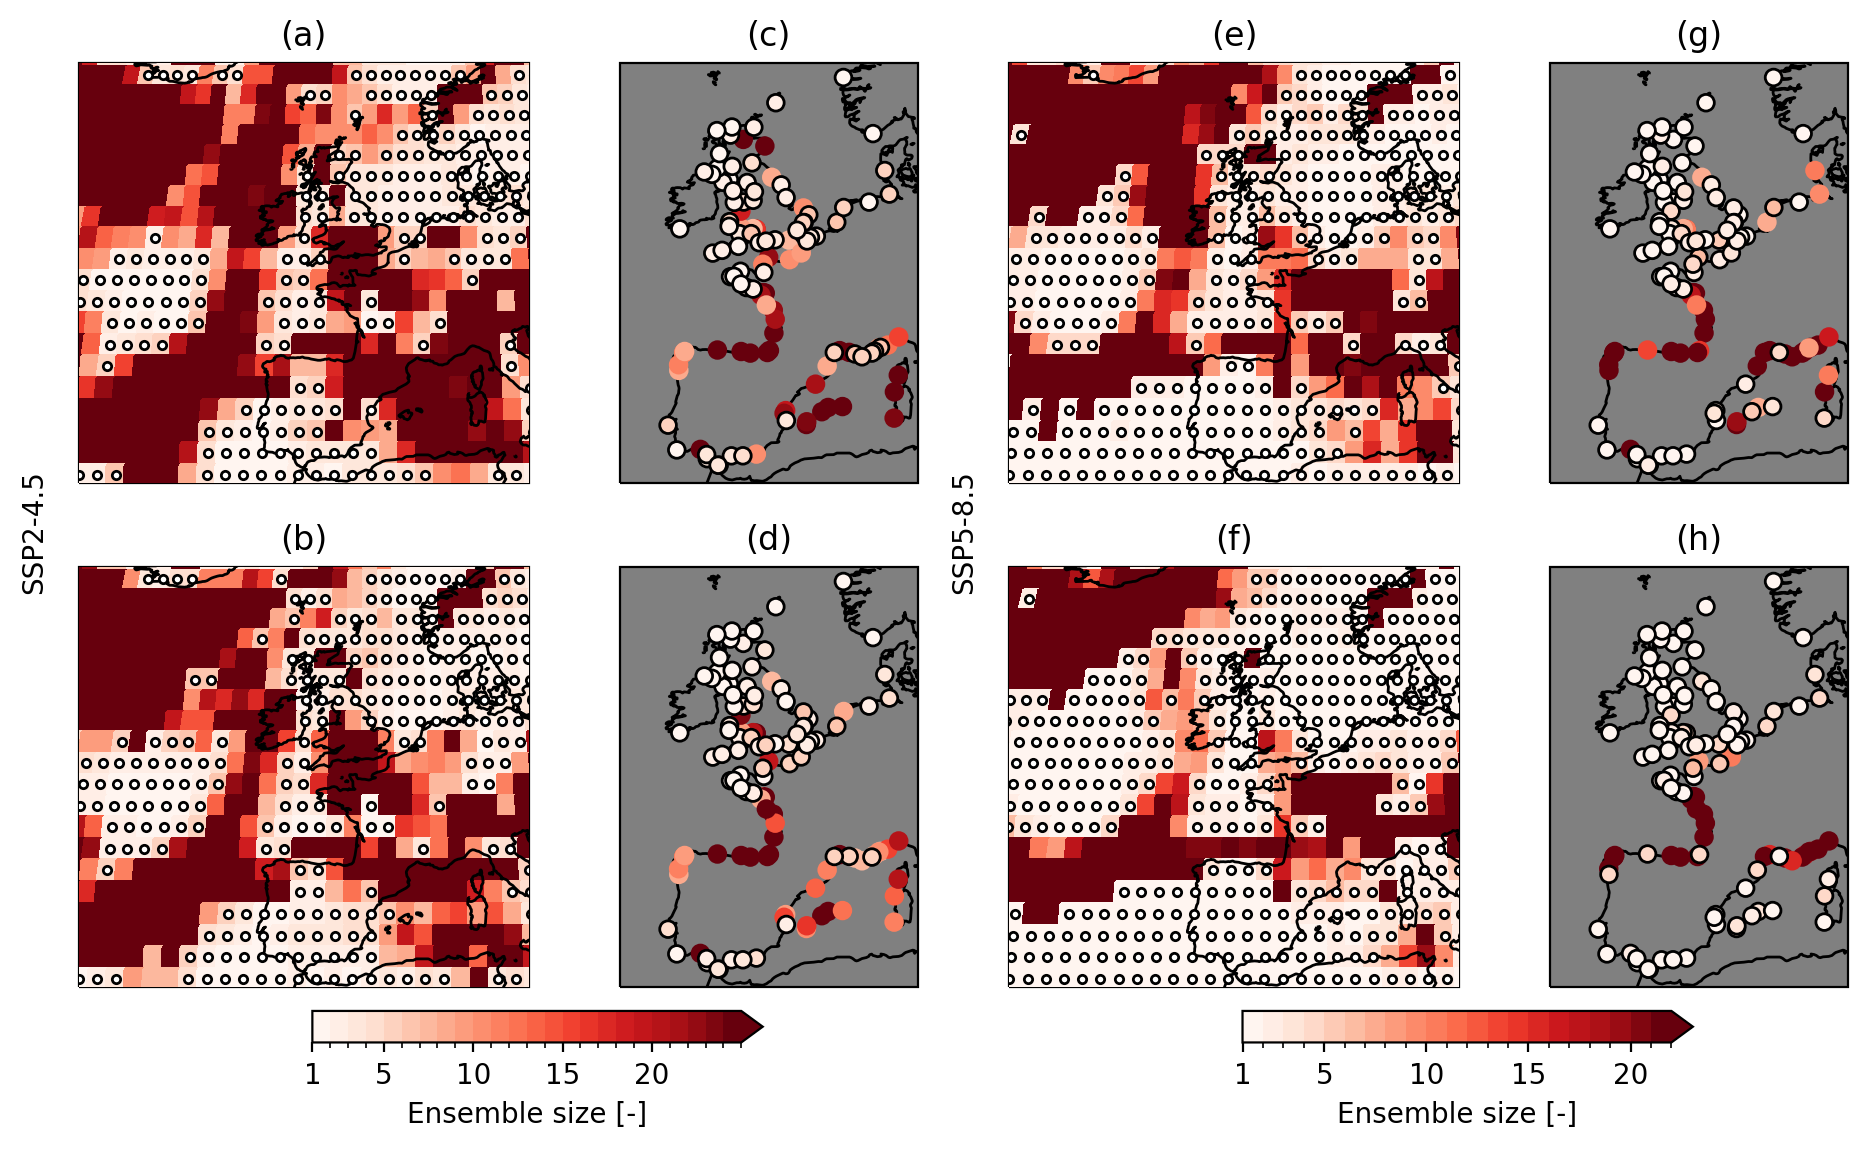

In [21]:
cmap = plt.cm.Reds # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(1, 25, 25)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        
np.random.seed(seed=0)

fig=plt.figure(figsize=(12,6)) #generate figure  
gs = fig.add_gridspec(2,6)
gs.update(wspace=.001)

for s,ssp in enumerate(['ssp245','ssp585']):
    for w,window in enumerate(np.array([2060,2080])):
        ssp_ds_diff = (n_wp.sel(window=window)-n_wp.sel(window=2000)).sel(ssp=ssp)#n_wp_diff.sel(ssp=ssp)

        '''
        finite_mems = np.isfinite(ssp_ds_diff.isel(latitude=0,longitude=0))

        members= np.zeros((len(ssp_ds_diff.source_id)))
        for i in np.arange(len(ssp_ds_diff.source_id)):
            try:
                members[i] = np.where(finite_mems[i,:])[0][0]
            except:
                members[i] = 0
        ix = xr.DataArray(members,dims=['source_id'],coords={'source_id':ssp_ds_diff.source_id})
        '''
        onemem_ens = ssp_ds_diff.sel(source_id='CanESM5').dropna(dim='member_id')#ssp_ds_diff.isel(member_id=ix.astype('int')).dropna(dim='source_id')
        n_samps = 2000
        for i in np.arange(len(onemem_ens.member_id)-1):
            n_models = i+1
            combs = list(itertools.combinations(np.arange(len(onemem_ens.member_id)), n_models))
            if len(combs)>n_samps:
                idx=np.random.randint(0,len(combs),size=n_samps)
                idx_ds = xr.DataArray(np.array([combs[k] for k in idx]),dims=['n','model'])
            else:
                idx_ds = xr.DataArray(np.array([combs[k] for k in np.arange(len(combs))]),dims=['n','model'])
        
            signs = np.sign(onemem_ens.isel(member_id=idx_ds).mean(dim='model'))
            frac_positive = (signs==np.sign(ssp_ds_diff.mean(dim='member_id').mean(dim='source_id'))).sum(dim='n')/len(signs.n)
            if i==0:
                frac_positive_ds = frac_positive
            else:
                frac_positive_ds = xr.concat((frac_positive_ds,frac_positive),dim='n_models')
        frac_positive_ds = frac_positive_ds.assign_coords({'n_models':np.arange(len(onemem_ens.member_id)-1)+1})
        
        
        agrees = frac_positive_ds>=.9
        
        subsequent_sum = frac_positive_ds.copy(deep=True)
        for k in np.arange(len(agrees.n_models)):
            subsequent_sum[k,:,:] = agrees.where(agrees==1).isel(n_models=np.arange(k,len(agrees.n_models))).sum(dim='n_models',skipna=False).values
        
        
        #test = frac_positive_ds.where(frac_positive_ds>=.9,-999)
        
        agrees = agrees.where(np.isfinite(subsequent_sum),-999)
        #test = test.where(test!=0)
        first_n = agrees.argmax(dim='n_models')#.where(~np.isfinite(frac_positive_ds.where((frac_positive_ds>.1) & (frac_positive_ds<.9))))
        #first_n = first_n.where(frac_positive_ds.where(frac_positive_ds>=.9).all(dim='n_models'))
        first_n = first_n.where(agrees.any(dim='n_models'),100)
        first_n = first_n.where(np.isfinite(subsequent_sum.isel(n_models=first_n.astype('int'))),100)
        first_n = first_n+1
        #first n and all subsequent n also?
        
        
        
        if ssp=='ssp245':                                                                             
            ax = plt.subplot(gs[w,0:2],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

            sc = (first_n).plot(cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            [LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=5)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
            if w==1:
                cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.55, -.1,1,.075),bbox_transform=ax.transAxes)
                cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Ensemble size [-]',extend='max')
                cb.set_ticks(np.array([1,5,10,15,20]))
                cb.set_ticklabels(['1','5','10','15','20'])
            ax.set_title(['(a)','(b)'][w])

            sc.set_edgecolor('face')
         
        
        if ssp=='ssp585':                                                                             
            ax = plt.subplot(gs[w,3:5],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            
            cmap = plt.cm.Reds # define the colormap
            # extract all colors from the .jet map
            cmaplist = [cmap(i) for i in range(cmap.N)]

            cmap = mpl.colors.LinearSegmentedColormap.from_list(
                'Custom cmap', cmaplist, cmap.N)
            bounds = np.linspace(1, 22, 22)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
            sc = (first_n).plot(cmap=cmap,transform=ccrs.PlateCarree(),zorder=3,ax=ax,norm=norm,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            [LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=5)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
            if w==1:
                cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.55, -.1,1,.075),bbox_transform=ax.transAxes)
                cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Ensemble size [-]',extend='max')
                cb.set_ticks(np.array([1,5,10,15,20]))
                cb.set_ticklabels(['1','5','10','15','20'])
            ax.set_title(['(e)','(f)'][w])

            sc.set_edgecolor('face')
        if (w==0):
            ax.annotate(['SSP2-4.5','SSP5-8.5'][s],xy=(-.13,-.25),xycoords='axes fraction',rotation=90)  
                
           
        #surges
        ssp_ds_diff = (n_sp.sel(window=window)-n_sp.sel(window=2000)).sel(ssp=ssp)#n_wp_diff.sel(ssp=ssp)



        onemem_ens = ssp_ds_diff.sel(source_id='CanESM5').dropna(dim='member_id')
        n_samps = 2000
        for i in np.arange(len(onemem_ens.member_id)-1):
            n_models = i+1
            combs = list(itertools.combinations(np.arange(len(onemem_ens.member_id)), n_models))
            if len(combs)>n_samps:
                idx=np.random.randint(0,len(combs),size=n_samps)
                idx_ds = xr.DataArray(np.array([combs[k] for k in idx]),dims=['n','model'])
            else:
                idx_ds = xr.DataArray(np.array([combs[k] for k in np.arange(len(combs))]),dims=['n','model'])

            signs = np.sign(onemem_ens.isel(member_id=idx_ds).mean(dim='model'))
            frac_positive = (signs==np.sign(ssp_ds_diff.mean(dim='member_id').mean(dim='source_id'))).sum(dim='n')/len(signs.n)
            if i==0:
                frac_positive_ds = frac_positive
            else:
                frac_positive_ds = xr.concat((frac_positive_ds,frac_positive),dim='n_models')
        frac_positive_ds = frac_positive_ds.assign_coords({'n_models':np.arange(len(onemem_ens.member_id)-1)+1})


        agrees = frac_positive_ds>=.9

        subsequent_sum = frac_positive_ds.copy(deep=True)
        for k in np.arange(len(agrees.n_models)):
            subsequent_sum[k,:] = agrees.where(agrees==1).isel(n_models=np.arange(k,len(agrees.n_models))).sum(dim='n_models',skipna=False).values


        #test = frac_positive_ds.where(frac_positive_ds>=.9,-999)

        agrees = agrees.where(np.isfinite(subsequent_sum),-999)
        #test = test.where(test!=0)
        first_n = agrees.argmax(dim='n_models')#.where(~np.isfinite(frac_positive_ds.where((frac_positive_ds>.1) & (frac_positive_ds<.9))))
        #first_n = first_n.where(frac_positive_ds.where(frac_positive_ds>=.9).all(dim='n_models'))
        first_n = first_n.where(agrees.any(dim='n_models'),100)
        first_n = first_n.where(np.isfinite(subsequent_sum.isel(n_models=first_n.astype('int'))),100)
        first_n = first_n+1
        #first n and all subsequent n also?


        if ssp=='ssp245':                                                                             
            ax = plt.subplot(gs[w,2],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            sc=ax.scatter(n_sp.lon[first_n<7],n_sp.lat[first_n<7],c=first_n[first_n<7],cmap=cmap,norm=norm,edgecolor='black',transform=ccrs.PlateCarree(),zorder=4)
            sc=ax.scatter(n_sp.lon[first_n>6],n_sp.lat[first_n>6],c=first_n[first_n>6],cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=3)

            #sc = (first_n).plot(cmap='Reds',vmin=1,vmax=22,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            #[LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            #ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=1)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
            
            ax.set_title(['(c)','(d)'][w])
            
            sc.set_edgecolor('face')
            
        if ssp=='ssp585':                                                                       
            ax = plt.subplot(gs[w,5],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            sc=ax.scatter(n_sp.lon[first_n<7],n_sp.lat[first_n<7],c=first_n[first_n<7],cmap=cmap,norm=norm,edgecolor='black',transform=ccrs.PlateCarree(),zorder=4)
            sc=ax.scatter(n_sp.lon[first_n>6],n_sp.lat[first_n>6],c=first_n[first_n>6],cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=3)

            #sc = (first_n).plot(cmap='Reds',vmin=1,vmax=22,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
            #first_n.plot.contour(levels=[1,6],colors=['black','grey'],transform=ccrs.PlateCarree(),ax=ax,zorder=10)


            #[LON,LAT] = np.meshgrid(ssp_ds_diff.longitude,ssp_ds_diff.latitude)
            #ax.scatter(LON.flatten()[first_n.values.flatten()<7],LAT.flatten()[first_n.values.flatten()<7],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=1)
            #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
            ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
           
            ax.set_title(['(g)','(h)'][w])

            sc.set_edgecolor('face')
      
#fig.savefig('Figures/req_enssize_cmip6.pdf',format='pdf',dpi=300,bbox_inches='tight')
